In [2]:
!pip install lifetimes

## LOAD AND READ DATA

In [3]:
import pandas as pd
from lifetimes.datasets import load_dataset

In [4]:
transactions = load_dataset(
    filename='CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

In [5]:
transactions.head()

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96
3,4,1,1997-12-12,2,26.48
4,21,2,1997-01-01,3,63.34


## CONVERT TO RFM

Before fitting the BG-NBD model, we need to first restructure this table to the canonical “RFM” format. A table in the RFM format has rows that represent individual customers and the following columns:

frequency, which represents the number of repeat purchases the customer has made.
recency, which represents the “age” of the customer when they made their most recent purchases.
T, which represents the “age” of the customer at the end of the observation period.
monetary_value, an optional column which represents the average value of a given customer’s purchases, excluding the first purchase.

In [6]:
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(transactions=transactions,
                                         customer_id_col='customer_id',
                                         datetime_col='date',
                                         monetary_value_col = 'amount',
                                         observation_period_end=pd.to_datetime('1998-06-30'),
                                         freq='W')

In [7]:
rfm.head(3)

,frequency,recency,T,monetary_value
customer_id,,,,
4,3.0,49.0,78.0,23.723333
18,0.0,0.0,78.0,0.000000
21,1.0,2.0,78.0,11.770000


## Calibration-holdout split

In [8]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=transactions,
                                               customer_id_col='customer_id', 
                                               datetime_col='date',
                                               monetary_value_col = 'amount',
                                               freq='W',
                                               calibration_period_end='1998-01-01',
                                               observation_period_end='1998-06-30' )

In [9]:
rfm_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.0,26.0
18,0.0,0.0,52.0,0.000000,0.0,0.0,26.0
21,1.0,2.0,52.0,11.770000,0.0,0.0,26.0


## Training, Prediction and Evaluation

#FIT THE MODEL

In [10]:
from lifetimes import BetaGeoFitter

# instantiation of BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fitting of BG-NBD model
bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
        recency=rfm_cal_holdout['recency_cal'], 
        T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.53, alpha: 6.73, b: 1.97, r: 0.28>

In [12]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.281847,0.014034,0.254340,0.309354
alpha,6.732810,0.532304,5.689494,7.776126
a,0.532360,0.122632,0.292000,0.772719
b,1.971260,0.575322,0.843628,3.098892


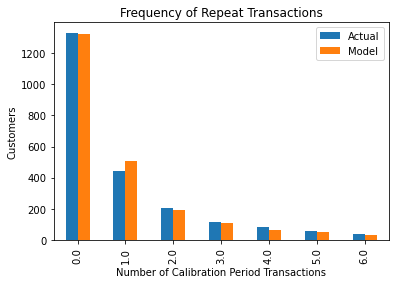

In [13]:
from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf) 

## Making a Prediction

In [14]:
# First, we choose a sample customer. 
sample_customer = rfm_cal_holdout.iloc[20] 

# Let's inspect his frequency, recency and T both for the calibration and observation periods:
sample_customer

frequency_cal              3.000000
recency_cal               28.000000
T_cal                     52.000000
monetary_value_cal        25.076667
frequency_holdout          2.000000
monetary_value_holdout    29.480000
duration_holdout          26.000000
Name: 226, dtype: float64

In [15]:
# This function calculates the conditional expected number of transactions in the given time length
n_transactions_pred = bgf.predict(t=26, # we set it to 26 weeks (the length of the observation period)
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])

n_transactions_pred # = 0.7647440846242359

0.7647440846242523

In [16]:
alive_prob = bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'], 
                                               recency=sample_customer['recency_cal'], 
                                               T=sample_customer['T_cal'])

alive_prob # = 0.57089896

array([0.57089896])

## Comparison of real and predicted number of transactions

In [17]:
# the real number of transactions in the observation period, which equals frequency_holdout + 1
rfm_cal_holdout["n_transactions_holdout_real"]  = rfm_cal_holdout["frequency_holdout"] + 1

# the predicted number of transactions in the next 26 weeks (length of the observation period)
rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=26, 
                                                    frequency=rfm_cal_holdout['frequency_cal'], 
                                                    recency=rfm_cal_holdout['recency_cal'], 
                                                    T=rfm_cal_holdout['T_cal'])

# comparison of the real and predicted transactions
rfm_cal_holdout[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,
4,1.0,1.155554
18,1.0,0.118167
21,1.0,0.128974
50,1.0,0.118167
60,1.0,0.126350


In [18]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true = rfm_cal_holdout["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout["n_transactions_holdout_pred"],
                          squared = False)

RMSE # = 1.3536793286521

1.3536793286520972

## Visualizing the MLE Gamma and Beta distributions

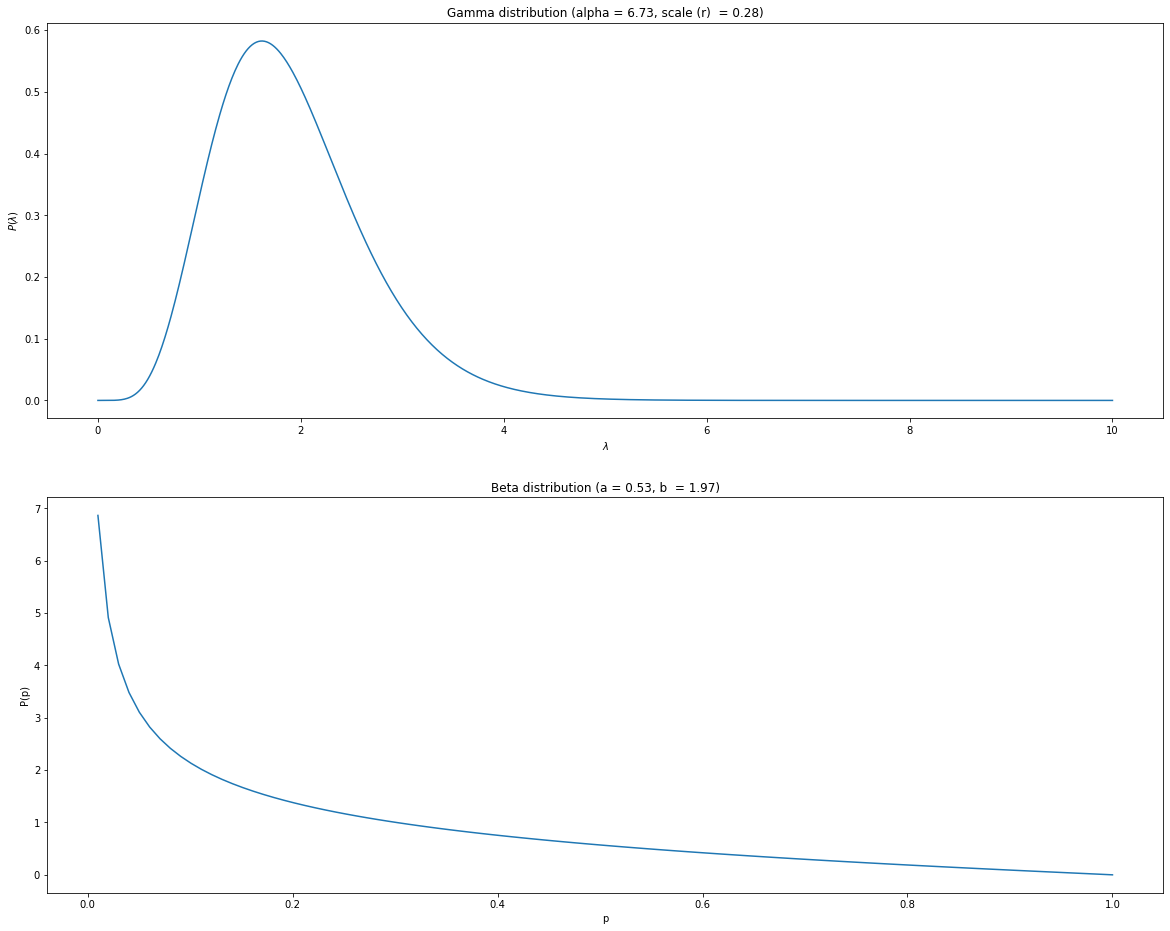

In [19]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows =2, figsize = (20, 16))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf.params_["alpha"], scale=bgf.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {bgf.params_["alpha"]:.2f}, scale (r)  = {bgf.params_["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf.params_["a"], b=bgf.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf.params_["a"]:.2f}, b  = {bgf.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()

## Frequency/Recency/Future Purchases Matrix

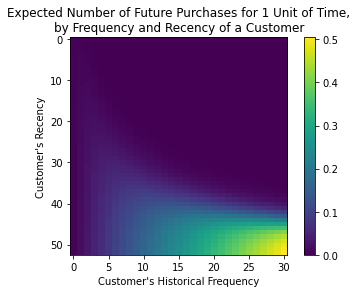

In [20]:
from lifetimes.plotting import plot_frequency_recency_matrix

_ = plot_frequency_recency_matrix(bgf)

## Frequency/Recency/Probability Alive Matrix

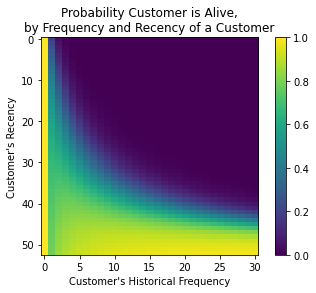

In [21]:
from lifetimes.plotting import plot_probability_alive_matrix

_ = plot_probability_alive_matrix(bgf)

## CLV estimation using BG-NBD

In [22]:
# the predicted number of transactions in the next 10 weeks
rfm_cal_holdout["n_transactions_10_pred"] = bgf.predict(t=10, 
                                                        frequency=rfm_cal_holdout['frequency_cal'], 
                                                        recency=rfm_cal_holdout['recency_cal'], 
                                                        T=rfm_cal_holdout['T_cal'])

# the probability of being alive
rfm_cal_holdout["alive_prob"] = bgf.conditional_probability_alive(frequency=rfm_cal_holdout['frequency_cal'], 
                                                                  recency=rfm_cal_holdout['recency_cal'], 
                                                                  T=rfm_cal_holdout['T_cal'])


# multiplication of alive probability x number of purchases x average past purchase
rfm_cal_holdout["value_10_pred"] = rfm_cal_holdout["alive_prob"]* \
                                   rfm_cal_holdout["n_transactions_10_pred"]*\
                                   rfm_cal_holdout["monetary_value_cal"]
                                   
                                     
rfm_cal_holdout[["value_10_pred", "alive_prob", "n_transactions_10_pred", "monetary_value_cal"]].head()


,value_10_pred,alive_prob,n_transactions_10_pred,monetary_value_cal
customer_id,,,,
4,9.53934,0.862647,0.466132,23.723333
18,0.00000,1.000000,0.046933,0.000000
21,0.14799,0.243428,0.051652,11.770000
50,0.00000,1.000000,0.046933,0.000000
60,0.00000,1.000000,0.050285,0.000000


In [23]:
rfm_cal_holdout["value_10_pred"].describe()

count    2357.000000
mean        5.178024
std        16.195977
min         0.000000
25%         0.000000
50%         0.000000
75%         2.453662
max       213.484909
Name: value_10_pred, dtype: float64

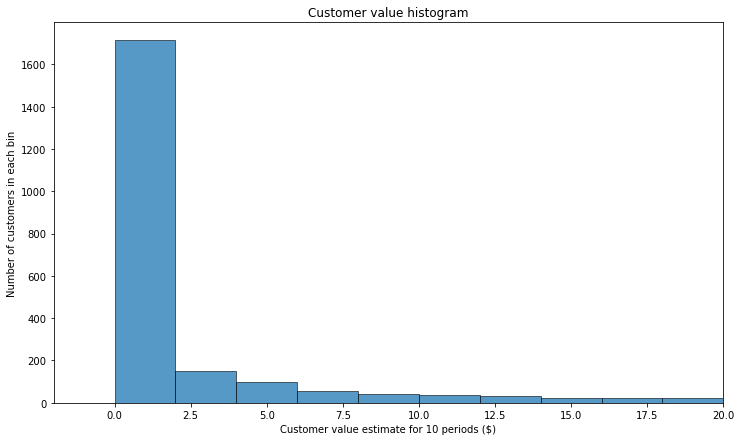

In [24]:
import seaborn as sns 

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.histplot(rfm_cal_holdout["value_10_pred"], 
                  kde=False, 
                  binwidth = 2)
ax.set_title(f'Customer value histogram')
ax.set_xlabel(r'Customer value estimate for 10 periods ($)')
ax.set_ylabel(r'Number of customers in each bin')
ax.set_xlim(-2,20)

plt.show()

## Proactive intervention

In [25]:
VALUE_10_PRED_THRESHOLD = 10

# filtering for high-value customers
rfm_cal_holdout.loc[rfm_cal_holdout["value_10_pred"]>VALUE_10_PRED_THRESHOLD, ["value_10_pred"]]

,value_10_pred
customer_id,
111,94.006160
133,22.670743
166,15.338678
167,22.797245
228,43.224262
...,...
23498,30.545742
23500,11.031599
23507,21.082439
